In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from simulation.diffusion import Diffusion

import signature.tensor_algebra as ta
from signature.ode_integration import *

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color= ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"])

## VIX coefficient

In [3]:
trunc = 3
e = ta.AlgebraBasis(dim=2, trunc=trunc * 2)

lam = jnp.array([1, 0.5]) * 5
sigma_ts = e[0] * 0.2 + e[2] * 0.5 + e[12] * 0.5 + e[222] * 3

vix_delta = 1 / 12
n_t_steps = 1000
t_grid_vix = np.linspace(0, vix_delta, n_t_steps)

esig_fm = ta.expected_bm_fm_signature(trunc=trunc * 2, lam=lam, t=vix_delta, n_points=n_t_steps, t_grid=t_grid_vix)

shuffle_table = ta.get_shuffle_table(table_trunc=trunc * 2, dim=2)
sigma_ts_sq = ta.shuffle_pow(sigma_ts, 2, shuffle_table=shuffle_table)

def get_vix_coef(sigma_sq: ta.TensorSequence, t_grid: jax.Array, esig: ta.TensorSequence, lam: jax.Array):
    return ta.from_array(
        jnp.trapezoid(
            y=ta.D_timedep(ta.right_proj_on_seq(sigma_sq, esig), t_grid, lam).array / vix_delta,
            x=t_grid, axis=1
        ),
        trunc=trunc * 2,
        dim=2
    )

vix_coef = get_vix_coef(sigma_ts_sq, t_grid_vix, esig_fm, lam)
print(vix_coef)

0.0525175135028699*0 + 0.016149835434641022*1 + 0.19963596472472667*2 + 0.01076859521510285*11 + 0.14871634772464648*12 + 0.6065077967497179*22 + 0.8077053317153992*122 + 0.43615845150300814*212 + 0.06461157129061709*221 + 0.892298086347879*222 + 0.5707962369831311*1122 + 0.28539811849156554*1212 + 10.080133408328493*2222 + 6.849554843797573*12222 + 5.137166132848179*21222 + 3.4247774218987863*22122 + 1.7123887109493932*22212 + 102.74332265696358*222222


In [4]:
T = 0.5
t_grid_W = np.linspace(0, T, int(T * 365))
rng = np.random.default_rng(seed=42)
W = np.concatenate([[0], np.cumsum(rng.normal(size=len(t_grid_W) - 1) * np.sqrt(np.diff(t_grid_W)))])
path = np.vstack([t_grid_W, W]).T
W_sig = ta.path_to_fm_signature(path=path, trunc=trunc * 2, t_grid=t_grid_W, lam=lam)
W_sig.shape

(127, 182)

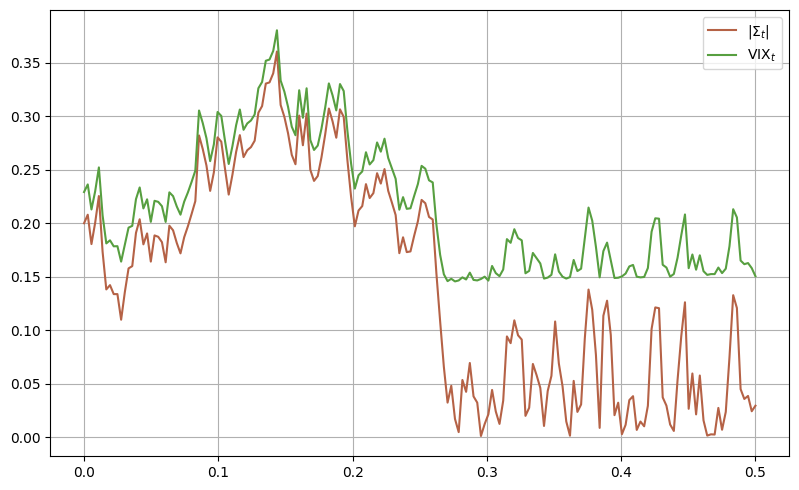

In [5]:
fig, ax = plt.subplots()

ax.plot(t_grid_W, np.abs(W_sig @ sigma_ts), label="$|\Sigma_t|$")
ax.plot(t_grid_W, np.sqrt(W_sig @ vix_coef), label="$\mathrm{VIX}_t$")
ax.legend()

#### Sanity check
$\mathbb{E}[\mathrm{VIX}_T^2] = \langle \ell^{\mathrm{VIX}^2}, \mathcal{E}^{\lambda}_T \rangle = \dfrac{1}{\Delta}\int_0^\Delta \langle \sigma^{2}, \mathcal{E}_{T + u}^\lambda\rangle du$

In [6]:
esig_T = ta.expected_bm_fm_signature(trunc=trunc * 2, lam=lam, t=T, n_points=1000)
vix_coef @ esig_T

Array(0.17733865, dtype=float64)

In [7]:
esig_vix_grid = ta.expected_bm_fm_signature(trunc=trunc * 2, lam=lam, t=T, t_grid=np.concatenate([t_grid_W, T + t_grid_vix]))
np.trapz(esig_vix_grid.array[:, t_grid_W.size:].T @ sigma_ts_sq.array, t_grid_vix) / vix_delta

0.17733754876164987

## Pricing the derivatives on VIX

In [10]:
def payoff_vix_squared(vix_squared):
    return vix_squared

def payoff_vix(vix_squared):
    return np.sqrt(vix_squared)

def payoff_call_on_vix(vix_squared, K):
    return np.maximum(np.sqrt(vix_squared) - K, 0)

In [11]:
payoff = payoff_vix_squared

## General MC pricing

In [73]:
from tqdm import tqdm
from simulation.monte_carlo import MonteCarlo

def get_mc_price(n_batches: int, batch_size: int, rng: np.random.Generator, get_sig_batch: Callable, **kwargs):
    mc_vix_square = None
    for _ in range(n_batches):
        sig_batch = get_sig_batch(size=batch_size, rng=rng, **kwargs)
        vix_squared_batch = vix_coef.array @ sig_batch.array[:, -1, :]

        if mc_vix_square is None:
            mc_vix_square = MonteCarlo(payoff(vix_squared_batch), confidence_level=0.95)
        else:
            mc_vix_square.add_batch(payoff(vix_squared_batch))
        print(mc_vix_square.results())
    return mc_vix_square.mean

#### Vanilla Monte Carlo on EFM-Signatures (terribly long)

In [85]:
def get_efm_sig_batch(size: int, rng: np.random.Generator, t_grid):
    diffusion = Diffusion(t_grid=t_grid, dim=1, size=size, rng=rng)
    W_traj = diffusion.brownian_motion()[:, 0, :]  # shape (size, len(t_grid))

    path = np.zeros((diffusion.t_grid.size, 2, size))
    path[:, 0, :] = np.reshape(diffusion.t_grid, (-1, 1))
    path[:, 1, :] = W_traj.T

    array = np.zeros((ta.number_of_words_up_to_trunc(trunc=sigma_ts.trunc, dim=sigma_ts.dim), path.shape[0], path.shape[2]))
    for i in tqdm(range(path.shape[2])):
        array[:, :, i] = ta.path_to_fm_signature(path=path[:, :, i], trunc=sigma_ts.trunc, t_grid=diffusion.t_grid, lam=lam).array
    W_sig_batch = ta.from_array(array, trunc=sigma_ts.trunc, dim=sigma_ts.dim)
    return W_sig_batch

In [86]:
%%time
rng = np.random.default_rng(seed=42)
t_grid_mc = np.linspace(0, T, int(T * 100))

get_mc_price(n_batches=3, batch_size=10**3, rng=rng, get_sig_batch=get_efm_sig_batch, t_grid=t_grid_mc)

100%|██████████| 1000/1000 [00:51<00:00, 19.40it/s]


0.18732000000000001 ± 0.02374


100%|██████████| 1000/1000 [00:45<00:00, 21.89it/s]


0.18179 ± 0.01521


100%|██████████| 1000/1000 [00:45<00:00, 22.12it/s]

0.17857 ± 0.01185


Array(0.17857418, dtype=float64)

#### Monte Carlo via the standard signatures using $\mathbb{W}^{\lambda}_{0, T} \overset{d}{=} \mathbb{W}_{0, \frac{1 - e^{-\lambda T}}{\lambda}}$.

In [87]:
def get_sig_batch(size: int, rng: np.random.Generator, t_grid):
    diffusion = Diffusion(t_grid=t_grid, dim=1, size=size, rng=rng)
    W_traj = diffusion.brownian_motion()[:, 0, :]  # shape (size, len(t_grid))

    path = np.zeros((diffusion.t_grid.size, 2, size))
    path[:, 0, :] = np.reshape(diffusion.t_grid, (-1, 1))
    path[:, 1, :] = W_traj.T

    array = np.zeros((ta.number_of_words_up_to_trunc(trunc=sigma_ts.trunc, dim=sigma_ts.dim), path.shape[0], path.shape[2]))
    for i in tqdm(range(path.shape[2])):
        array[:, :, i] = ta.path_to_signature(path=path[:, :, i], trunc=sigma_ts.trunc).array
    W_sig_batch = ta.from_array(array, trunc=sigma_ts.trunc, dim=sigma_ts.dim)
    return W_sig_batch

In [91]:
%%time
rng = np.random.default_rng(seed=42)
t_grid_mc = np.linspace(0, (1 - np.exp(-lam[0] * T)) / lam[0], int(T * 100))

get_mc_price(n_batches=3, batch_size=10**4, rng=rng, get_sig_batch=get_sig_batch, t_grid=t_grid_mc)

100%|██████████| 10000/10000 [00:01<00:00, 6840.66it/s]


0.17449 ± 0.00635


100%|██████████| 10000/10000 [00:01<00:00, 6705.60it/s]


0.1756 ± 0.00465


100%|██████████| 10000/10000 [00:01<00:00, 6736.21it/s]


0.17791 ± 0.00392
CPU times: total: 1.95 s
Wall time: 5.37 s


Array(0.17790514, dtype=float64)

## EFM-Sig of Brownian Cubatures

### Cubature of order 5 for the EFM-signature

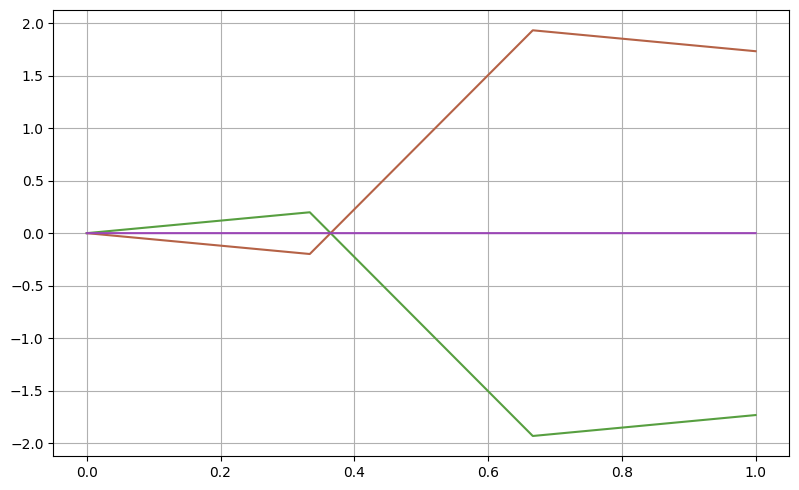

In [21]:
t = np.linspace(0, 1, 10000)

omega1 = ((t <= 1 / 3) * 0.5 * (4 - np.sqrt(22)) * t +
          (t > 1 / 3) * (t <= 2 / 3) * ((4 - np.sqrt(22)) / 6 + (-1 + np.sqrt(22)) * (t - 1 / 3)) +
          (t > 2 / 3) * ((2 + np.sqrt(22)) / 6 + 0.5 * (4 - np.sqrt(22)) * (t - 2 / 3)))

plt.plot(t, omega1 * np.sqrt(3))
plt.plot(t, -omega1 * np.sqrt(3))
plt.plot(t, np.zeros_like(t))

In [65]:
def dilation(path, T):
    new_path = np.zeros_like(path)
    new_path[:, 0] = T * path[:, 0]
    new_path[:, 1] = np.sqrt(T) * path[:, 1]
    return new_path

def get_cubature_base_efm_sig(base_paths, trunc, dT, lam):
    n_cubature = len(base_paths)
    dim = base_paths.shape[2]
    tree_sig = np.zeros((ta.number_of_words_up_to_trunc(trunc=trunc, dim=dim), n_cubature))

    for i in range(n_cubature):
        scaled_path = dilation(base_paths[i, :, :], dT)
        tree_sig[:, i] = ta.path_to_fm_signature(scaled_path, trunc=trunc, t_grid=scaled_path[:, 0], lam=lam).array[:, -1]
    return ta.from_array(tree_sig, trunc=trunc, dim=dim)

def get_iterated_cubature_efm_sig(base_paths, cubature_weights, trunc, T, lam, K):
    n_cubature = len(base_paths)
    dim = base_paths.shape[2]
    dT = T / K
    cubature_sig = get_cubature_base_efm_sig(base_paths, trunc=trunc, dT=T / K, lam=lam)

    iterated_cubature = cubature_sig
    iterated_cubature_weights = cubature_weights

    for l in range(K - 1):
        print(l)
        prev_tree_size = iterated_cubature.array.shape[1]
        new_array = np.zeros((iterated_cubature.array.shape[0], prev_tree_size * n_cubature))
        iterated_cubature_weights = np.outer(cubature_weights, iterated_cubature_weights).flatten()
        for k in range(n_cubature):
            new_array[:, prev_tree_size * k: prev_tree_size * (k+1)] = ta.tensor_prod(
                ta.D(iterated_cubature, dt=dT, lam=lam),
                cubature_sig.subsequence((k, ))
            ).array
        iterated_cubature = ta.from_array(new_array, trunc=trunc, dim=dim)
    return iterated_cubature, iterated_cubature_weights

In [93]:
# Order 5 cubature
base_paths_5 = np.array(
   [
    [[0, 0],
     [1/3, np.sqrt(3) / 6 * (4 - np.sqrt(22))],
     [2/3, np.sqrt(3) / 6 * (2 + np.sqrt(22))],
     [1, np.sqrt(3)]],
    [[0, 0],
     [1/3, -np.sqrt(3) / 6 * (4 - np.sqrt(22))],
     [2/3, -np.sqrt(3) / 6 * (2 + np.sqrt(22))],
     [1, -np.sqrt(3)]],
    [[0, 0],
     [1/3, 0],
     [2/3, 0],
     [1, 0]]
   ]
)
cubature_weights_5 = np.array([1/6, 1/6, 2/3])

In [55]:
# Precomputing the cubature
iterated_cubature, iterated_cubature_weights = get_iterated_cubature_efm_sig(base_paths=base_paths_5, cubature_weights=cubature_weights_5,
                                                                             trunc=sigma_ts.trunc, T=T, lam=lam, K=14)
iterated_cubature.shape

0
1
2
3
4
5
6
7
8
9
10
11
12


(127, 4782969)

In [57]:
%%time
# Pricing
payoff(vix_coef @ iterated_cubature) @ iterated_cubature_weights

CPU times: total: 93.8 ms
Wall time: 245 ms


Array(0.17693428, dtype=float64)

### Order 3 cubature: Approximation by a random walk

In [94]:
base_paths_3 = np.array(
   [
    [[0, 0],
     [1.0, 1.0]],
    [[0, 0],
     [1.0, -1.0]],
   ]
)

cubature_weights_3 = np.array([0.5, 0.5])

In [67]:
# Precomputing the cubature
iterated_cubature, iterated_cubature_weights = get_iterated_cubature_efm_sig(base_paths=base_paths_3, cubature_weights=cubature_weights_3,
                                                                             trunc=sigma_ts.trunc, T=T, lam=lam, K=22)
iterated_cubature.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


(127, 4194304)

In [68]:
%%time
# Pricing
payoff(vix_coef @ iterated_cubature) @ iterated_cubature_weights

CPU times: total: 188 ms
Wall time: 480 ms


Array(0.17354338, dtype=float64)

## Cubatures of the standard signature via $\mathbb{W}^{\lambda}_{0, T} \overset{d}{=} \mathbb{W}_{0, \frac{1 - e^{-\lambda T}}{\lambda}}$.

In [96]:
def get_cubature_base_sig(base_paths, trunc, dT):
    n_cubature = len(base_paths)
    dim = base_paths.shape[2]
    tree_sig = np.zeros((ta.number_of_words_up_to_trunc(trunc=trunc, dim=dim), n_cubature))

    for i in range(n_cubature):
        scaled_path = dilation(base_paths[i, :, :], dT)
        tree_sig[:, i] = ta.path_to_signature(scaled_path, trunc=trunc).array[:, -1]
    return ta.from_array(tree_sig, trunc=trunc, dim=dim)

def get_iterated_cubature_sig(base_paths, cubature_weights, trunc, T, K):
    n_cubature = len(base_paths)
    dim = base_paths.shape[2]
    cubature_sig = get_cubature_base_sig(base_paths, trunc=trunc, dT=T / K)

    iterated_cubature = cubature_sig
    iterated_cubature_weights = cubature_weights

    for l in range(K - 1):
        print(l)
        prev_tree_size = iterated_cubature.array.shape[1]
        new_array = np.zeros((iterated_cubature.array.shape[0], prev_tree_size * n_cubature))
        iterated_cubature_weights = np.outer(cubature_weights, iterated_cubature_weights).flatten()
        for k in range(n_cubature):
            new_array[:, prev_tree_size * k: prev_tree_size * (k+1)] = ta.tensor_prod(
                iterated_cubature,
                cubature_sig.subsequence((k, ))
            ).array
        iterated_cubature = ta.from_array(new_array, trunc=trunc, dim=dim)
    return iterated_cubature, iterated_cubature_weights

In [97]:
# Precomputing the cubature
iterated_cubature, iterated_cubature_weights = get_iterated_cubature_sig(base_paths=base_paths_5, cubature_weights=cubature_weights_5,
                                                                             trunc=sigma_ts.trunc, T=(1 - np.exp(-lam[0] * T)) / lam[0], K=14)
iterated_cubature.shape

0
1
2
3
4
5
6
7
8
9
10
11
12


(127, 4782969)

In [98]:
%%time
# Pricing
payoff(vix_coef @ iterated_cubature) @ iterated_cubature_weights

CPU times: total: 797 ms
Wall time: 1.45 s


Array(0.17731128, dtype=float64)

In [99]:
# Precomputing the cubature
iterated_cubature, iterated_cubature_weights = get_iterated_cubature_sig(base_paths=base_paths_3, cubature_weights=cubature_weights_3,
                                                                         trunc=sigma_ts.trunc, T=(1 - np.exp(-lam[0] * T)) / lam[0], K=22)
iterated_cubature.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


(127, 4194304)

In [101]:
%%time
# Pricing
payoff(vix_coef @ iterated_cubature) @ iterated_cubature_weights

CPU times: total: 156 ms
Wall time: 329 ms


Array(0.17479315, dtype=float64)